In [30]:
# CELL 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, HBox, VBox, Layout
import glob
import os
import scipy.io as sio

# Style settings for better monograph plots
plt.style.use('seaborn-v0_8-paper') # Use a style suitable for papers
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 150, # Increase DPI for higher resolution figures
    'savefig.dpi': 300 # High DPI for saved figures
})

print("Libraries imported and plotting style set.")

Libraries imported and plotting style set.


In [51]:
# CELL 2: Configuration - Set Paths and Simulation Hash
# --- USER CONFIGURATION ---

# Path to the directory containing the golden data .npy files
# Adjust this path if your notebook is not in the project root
GOLDEN_DATA_DIR = Path("../data_lake/golden_data")

# Path to the directory containing the raw simulation output (.mat files)
# BRONZE_DATA_DIR = Path("../data_lake/bronze_data")

# --- Find wellSols file ---
# Assuming case name is 'GCS01', adjust if needed or extract from config/DB
CASE_NAME = "GCS01"
# well_sols_files = list()
well_sols_file = f"wellSols_{CASE_NAME}.mat"

print(f"\nAttempting to load Well Solutions data")
print(f"Well Solutions file: {well_sols_file}")

# Specify the simulation hash you want to visualize.
# If set to None, the notebook will try to find the first available hash.
# SIMULATION_HASH = "XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p15e01_rho_h2o_1p00e03_src_2p10em01"
# SIMULATION_HASH = "XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p23e01_rho_h2o_1p00e03_src_2p10em01"
# SIMULATION_HASH = "XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p31e01_rho_h2o_1p00e03_src_2p10em01"
SIMULATION_HASH = "XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p50e01_rho_h2o_1p00e03_src_2p10em01"
# --- END USER CONFIGURATION ---

# --- Find Simulation Hash if not specified ---
if SIMULATION_HASH is None:
    try:
        # Look for any pressure file to determine an available hash
        pressure_files = list(GOLDEN_DATA_DIR.glob("pressure_*.npy"))
        if not pressure_files:
            raise FileNotFoundError("No pressure_*.npy files found.")
        # Extract hash from the first file found
        filename = pressure_files[0].name # e.g., pressure_40cd0775.npy
        parts = filename.split('_')
        if len(parts) < 2:
             raise ValueError(f"Could not parse hash from filename: {filename}")
        SIMULATION_HASH = parts[1].replace('.npy', '')
        print(f"Simulation hash not specified, automatically using: {SIMULATION_HASH}")
    except Exception as e:
        print(f"Error finding simulation hash: {e}")
        # Set a placeholder to avoid crashing later cells, but data loading will fail
        SIMULATION_HASH = "ERROR_HASH_NOT_FOUND"

# Construct file paths
pressure_file = GOLDEN_DATA_DIR / f"pressure_{SIMULATION_HASH}.npy"
brine_sat_file = GOLDEN_DATA_DIR / f"brine_saturation_{SIMULATION_HASH}.npy"
gas_sat_file = GOLDEN_DATA_DIR / f"gas_saturation_{SIMULATION_HASH}.npy"

print(f"Attempting to load data for hash: {SIMULATION_HASH}")
print(f"Pressure file: {pressure_file}")
print(f"Brine Saturation file: {brine_sat_file}")
print(f"Gas Saturation file: {gas_sat_file}")


Attempting to load Well Solutions data
Well Solutions file: wellSols_GCS01.mat
Attempting to load data for hash: XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p50e01_rho_h2o_1p00e03_src_2p10em01
Pressure file: ../data_lake/golden_data/pressure_XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p50e01_rho_h2o_1p00e03_src_2p10em01.npy
Brine Saturation file: ../data_lake/golden_data/brine_saturation_XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p50e01_rho_h2o_1p00e03_src_2p10em01.npy
Gas Saturation file: ../data_lake/golden_data/gas_saturation_XNaCl_1p00em01_cp_rock_4p00em05_pe_5p00e00_pres_ref_3p50e01_rho_h2o_1p00e03_src_2p10em01.npy


In [52]:
# CELL 3: Load Data
try:
    pressure_data = np.load(pressure_file)
    brine_sat_data = np.load(brine_sat_file)
    gas_sat_data = np.load(gas_sat_file)

    # --- Data Exploration ---
    print("--- Data Loaded Successfully ---")
    print(f"Pressure shape (i, j, k, t): {pressure_data.shape}")
    print(f"Brine Saturation shape (i, j, k, t): {brine_sat_data.shape}")
    print(f"Gas Saturation shape (i, j, k, t): {gas_sat_data.shape}")

    # Extract dimensions
    i_dim, j_dim, k_dim, t_dim = pressure_data.shape
    print(f"\nGrid Dimensions: i={i_dim}, j={j_dim}, k={k_dim}")
    print(f"Number of Timesteps: {t_dim}")

    # Check for NaNs (which represent inactive cells)
    print(f"\nNaN count in pressure: {np.isnan(pressure_data).sum()} / {pressure_data.size}")
    print(f"NaN count in brine saturation: {np.isnan(brine_sat_data).sum()} / {brine_sat_data.size}")
    print(f"NaN count in gas saturation: {np.isnan(gas_sat_data).sum()} / {gas_sat_data.size}")

    # Basic Stats (ignoring NaNs)
    print(f"\nPressure Range: [{np.nanmin(pressure_data):.2e}, {np.nanmax(pressure_data):.2e}]")
    print(f"Brine Sat Range: [{np.nanmin(brine_sat_data):.3f}, {np.nanmax(brine_sat_data):.3f}]")
    print(f"Gas Sat Range: [{np.nanmin(gas_sat_data):.3f}, {np.nanmax(gas_sat_data):.3f}]")

except FileNotFoundError:
    print(f"ERROR: One or more data files not found for hash '{SIMULATION_HASH}' in '{GOLDEN_DATA_DIR}'.")
    print("Please check the path and hash.")
    # Assign None to prevent later errors, although plots won't work
    pressure_data, brine_sat_data, gas_sat_data = None, None, None
    i_dim, j_dim, k_dim, t_dim = 0, 0, 0, 0
except Exception as e:
    print(f"An error occurred loading data: {e}")
    pressure_data, brine_sat_data, gas_sat_data = None, None, None
    i_dim, j_dim, k_dim, t_dim = 0, 0, 0, 0


--- Data Loaded Successfully ---
Pressure shape (i, j, k, t): (81, 58, 20, 10)
Brine Saturation shape (i, j, k, t): (81, 58, 20, 10)
Gas Saturation shape (i, j, k, t): (81, 58, 20, 10)

Grid Dimensions: i=81, j=58, k=20
Number of Timesteps: 10

NaN count in pressure: 788880 / 939600
NaN count in brine saturation: 788880 / 939600
NaN count in gas saturation: 788880 / 939600

Pressure Range: [3.20e+07, 3.71e+07]
Brine Sat Range: [0.118, 1.000]
Gas Sat Range: [0.000, 0.882]


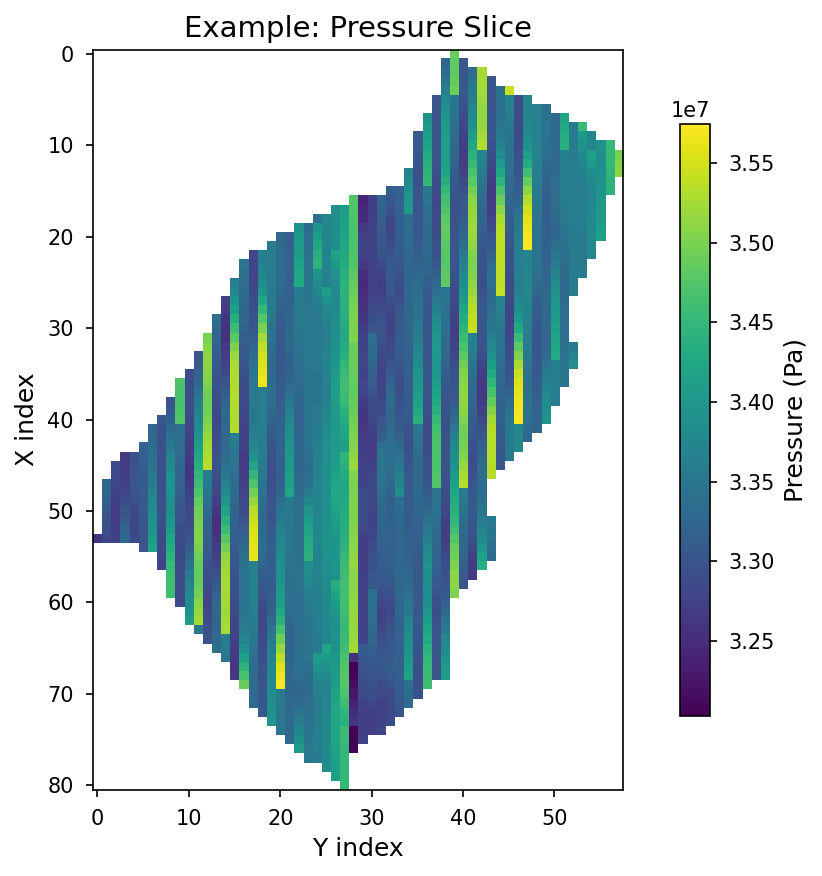

In [53]:
# CELL 4: Plotting Function
def plot_slice(data_3d, title, cmap, vmin=None, vmax=None, cbar_label="Value", aspect='equal'):
    """Plots a 2D slice using imshow, handling NaNs."""
    fig, ax = plt.subplots(figsize=(8, 6)) # Adjust figsize as needed

    # Use a copy to avoid modifying original data if masking
    plot_data = data_3d.copy()

    # Mask NaNs for plotting (optional: imshow handles NaNs by default,
    # but explicit masking can be useful with set_bad)
    # plot_data = np.ma.masked_invalid(plot_data)

    im = ax.imshow(plot_data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', aspect=aspect)
    # cmap.set_bad(color='lightgray') # Set color for NaN values

    cbar = fig.colorbar(im, ax=ax, shrink=0.8) # Add colorbar
    cbar.set_label(cbar_label)

    ax.set_title(title)
    ax.set_xlabel("Y index")
    ax.set_ylabel("X index")
    ax.invert_yaxis() # Often conventional for matrix plotting
    plt.tight_layout() # Adjust layout
    plt.show()

# --- Example usage (if data loaded): ---
if pressure_data is not None:
    example_slice = pressure_data[:, :, 0, 0] # first layer, first timestep
    plot_slice(example_slice, "Example: Pressure Slice", "viridis", cbar_label="Pressure (Pa)") # Assuming Pa, adjust if needed

In [54]:
# CELL 5: Interactive 2D Slice Viewer (XY Plane)

def interactive_plot_xy(timestep, k_layer):
    """Function called by the interactive widgets."""
    if pressure_data is None:
        print("Data not loaded.")
        return

    # --- Pressure Plot ---
    p_slice = pressure_data[:, :, k_layer, timestep]
    fig_p, ax_p = plt.subplots(figsize=(7, 5.5))
    im_p = ax_p.imshow(p_slice, cmap='viridis', origin='lower', interpolation='nearest', aspect='equal')
    cbar_p = fig_p.colorbar(im_p, ax=ax_p, shrink=0.8)
    cbar_p.set_label("Pressure (Pa)") # Assuming Pa
    ax_p.set_title(f"Pressure: Timestep={timestep}, K-Layer={k_layer}")
    ax_p.set_xlabel("Y index")
    ax_p.set_ylabel("X index")
    ax_p.invert_yaxis()
    plt.tight_layout()
    plt.show()

    # --- Saturation Plots ---
    sw_slice = brine_sat_data[:, :, k_layer, timestep]
    sg_slice = gas_sat_data[:, :, k_layer, timestep]

    fig_s, (ax_sw, ax_sg) = plt.subplots(1, 2, figsize=(14, 5.5), sharey=True) # Shared Y axis

    # brine Saturation
    im_sw = ax_sw.imshow(sw_slice, cmap='Blues', vmin=0, vmax=1, origin='lower', interpolation='nearest', aspect='equal')
    cbar_sw = fig_s.colorbar(im_sw, ax=ax_sw, shrink=0.7)
    cbar_sw.set_label("Brine Saturation")
    ax_sw.set_title(f"Brine Saturation (Sw)")
    ax_sw.set_xlabel("Y index")
    ax_sw.set_ylabel("X index")
    ax_sw.invert_yaxis()

    # Gas Saturation
    im_sg = ax_sg.imshow(sg_slice, cmap='Reds', vmin=0, vmax=1, origin='lower', interpolation='nearest', aspect='equal')
    cbar_sg = fig_s.colorbar(im_sg, ax=ax_sg, shrink=0.7)
    cbar_sg.set_label("Gas Saturation")
    ax_sg.set_title(f"Gas Saturation (Sg)")
    ax_sg.set_xlabel("Y index")
    # ax_sg.set_ylabel("X index") # Y label shared
    ax_sg.invert_yaxis()

    fig_s.suptitle(f"Saturation: Timestep={timestep}, K-Layer={k_layer}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


# --- Create Widgets ---
if t_dim > 0 and k_dim > 0: # Only create widgets if dimensions are valid
    timestep_slider = widgets.IntSlider(min=0, max=t_dim - 1, step=1, value=0, description='Timestep:', continuous_update=False)
    k_layer_slider = widgets.IntSlider(min=0, max=k_dim - 1, step=1, value=k_dim // 2, description='K Layer:', continuous_update=False)

    # Layout for controls
    controls = VBox([timestep_slider, k_layer_slider])

    # Output widget to display plots
    plot_output = interactive_output(interactive_plot_xy, {'timestep': timestep_slider, 'k_layer': k_layer_slider})

    # Display controls and output
    display(controls, plot_output)
else:
    print("Cannot create interactive plot: Data dimensions are invalid or data failed to load.")


Output()

In [29]:
# CELL 5.5: Interactive 3D Plume Viewer

# Import necessary toolkit
from mpl_toolkits.mplot3d import Axes3D

def interactive_plot_3d(timestep, sg_threshold):
    """Function called by the interactive widgets for 3D plot."""
    if gas_sat_data is None: # Check if gas saturation data is loaded
        print("Gas saturation data not loaded.")
        return

    # Select data for the timestep
    sg_t = gas_sat_data[:, :, :, timestep]

    # Find grid cells where Sg > threshold (handle NaNs which represent inactive cells)
    active_cells_mask = ~np.isnan(sg_t) # Find non-NaN cells first
    plume_mask = (sg_t > sg_threshold) & active_cells_mask
    indices = np.argwhere(plume_mask) # Get [i, j, k] coordinates of plume cells

    # Create 3D plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    if indices.size == 0:
        print(f"No cells found with Sg > {sg_threshold} at timestep {timestep}")
        # Display empty axes for context
        ax.set_title(f"Gas Plume (Sg > {sg_threshold:.2f}): Timestep={timestep} (No Plume Found)")
        # Set consistent limits even when empty, using global dims if available
        if 'j_dim' in globals() and 'i_dim' in globals() and 'k_dim' in globals():
            ax.set_xlim(0, j_dim)
            ax.set_ylim(0, i_dim)
            ax.set_zlim(0, k_dim)
    else:
        i_coords, j_coords, k_coords = indices[:, 0], indices[:, 1], indices[:, 2]
        sg_values = sg_t[plume_mask] # Get the Sg values for coloring

        # Scatter plot: Plotting j vs i vs k to potentially align with 2D view
        sc = ax.scatter(j_coords, i_coords, k_coords, c=sg_values, cmap='Reds', vmin=sg_threshold, vmax=1.0, s=15, alpha=0.7)

        # Add colorbar
        cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
        cbar.set_label('Gas Saturation (Sg)')

        # Set title and limits
        ax.set_title(f"Gas Plume (Sg > {sg_threshold:.2f}): Timestep={timestep}")
        if 'j_dim' in globals() and 'i_dim' in globals() and 'k_dim' in globals():
           ax.set_xlim(0, j_dim)
           ax.set_ylim(0, i_dim)
           ax.set_zlim(0, k_dim)

    # Set labels regardless of whether there's data
    ax.set_xlabel("Y Index")
    ax.set_ylabel("X Index")
    ax.set_zlabel("Z Index")

    # Improve view angle
    ax.view_init(elev=20., azim=-65)

    plt.tight_layout()
    plt.show()


# --- Create Widgets ---
# Check if gas_sat_data was loaded successfully and t_dim is valid
if 'gas_sat_data' in globals() and gas_sat_data is not None and t_dim > 0:
    # Reuse the timestep_slider from Cell 5 for consistency
    sg_threshold_slider = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.1, description='Sg Threshold:', continuous_update=False, readout_format='.2f', layout=Layout(width='50%'))

    # Layout for controls (using the existing timestep slider)
    controls_3d = VBox([timestep_slider, sg_threshold_slider])

    # Output widget
    plot_output_3d = interactive_output(interactive_plot_3d, {'timestep': timestep_slider, 'sg_threshold': sg_threshold_slider})

    # Display
    print("--- 3D Gas Plume Viewer ---")
    display(controls_3d, plot_output_3d)
else:
    print("Cannot create 3D interactive plot: Gas saturation data not loaded or dimensions invalid.")


--- 3D Gas Plume Viewer ---


Output()

In [55]:
# CELL 2: Configuration - Define Paths

# Path to the directory containing the raw simulation output (.mat file)
# Assumes notebook is in 'notebooks/' dir, sibling to 'data_lake/'
# BRONZE_DATA_DIR = Path("../data_lake/bronze_data")

# --- USER CONFIGURATION ---
# Specify the exact .mat file containing states, G, grdecl etc.
# Adjust this name/path as needed
MAT_FILENAME = "wellSols_GCS01.mat" # Or whatever the correct file is
# --- END USER CONFIGURATION ---

mat_file_path = MAT_FILENAME

print(f"Attempting to load data from: {mat_file_path}")

# Remove or comment out the logic related to finding .npy files and SIMULATION_HASH
# identifier = SIMULATION_HASH
# pressure_file = ...
# water_sat_file = ...
# gas_sat_file = ...

Attempting to load data from: wellSols_GCS01.mat


In [56]:
# CELL 3: Load and Parse Data from .mat File

# Initialize variables in case loading fails
P, SW, SG = None, None, None
I, J, K, ts = 0, 0, 0, 0
mat_data_loaded = False

if 'mat_file_path' in globals():
    try:
        print(f"Loading {mat_file_path}...")
        # Load the .mat file (use simplify_cells for easier access)
        s = sio.loadmat(mat_file_path, simplify_cells=True)
        print("Finished loading.")

        # --- Parsing based on your script ---
        print("Parsing data structure...")
        # Grid dimensions (adjust indices if structure differs)
        try:
             # Attempt to access grid dimensions (indices might vary based on save format)
             grid_struct = s.get('G', s.get('grid')) # Try common names
             if grid_struct is None: raise KeyError("Grid 'G' or 'grid' not found")
             # Assuming G.cartDims structure, adjust if needed:
             dims = grid_struct['cartDims']
             I, J, K = int(dims[0]), int(dims[1]), int(dims[2])
        except (KeyError, TypeError, IndexError) as e:
             print(f"  WARNING: Could not parse grid dimensions automatically: {e}. Check .mat structure.")
             # Fallback or prompt user? For now, set to 0
             I, J, K = 0, 0, 0
             raise ValueError("Failed to parse Grid Dimensions (I, J, K)") from e

        ncells_total = np.prod([I, J, K])
        print(f"  Grid Dimensions: I={I}, J={J}, K={K} (Total Cells: {ncells_total})")

        # Timesteps
        try:
            states_data = s.get('states')
            if states_data is None: raise KeyError("'states' not found")
            ts = len(states_data) # Number of timesteps
        except (KeyError, TypeError) as e:
            print(f"  WARNING: Could not determine number of timesteps from 'states': {e}")
            ts = 0
            raise ValueError("Failed to parse number of Timesteps (ts)") from e
        print(f"  Number of Timesteps: {ts}")

        # Active cells (adjust indices if structure differs)
        try:
             # Assuming grdecl.actnum structure
             grdecl_struct = s.get('grdecl')
             if grdecl_struct is None: raise KeyError("'grdecl' not found")
             actnum = grdecl_struct['ACTNUM'] # Active cell flags (boolean or 0/1)
             actnum = np.array(actnum).flatten(order='F') # Flatten in Fortran order
             indices_to_get = np.where(actnum != 0)[0] # Indices of active cells (use != 0 for flexibility)
        except (KeyError, TypeError) as e:
             print(f"  WARNING: Could not parse active cells ('grdecl.ACTNUM'): {e}")
             indices_to_get = np.arange(ncells_total) # Fallback: assume all cells active
             print("  Fallback: Assuming all cells are active.")
             # raise ValueError("Failed to parse Active Cells (actnum/indices_to_get)") from e

        ncells_active = indices_to_get.shape[0]
        print(f"  Number of Active Cells: {ncells_active}")

        # Initialize arrays with NaN for inactive cells
        P_all = np.full((ncells_total, ts), np.nan)
        SW_all = np.full((ncells_total, ts), np.nan)
        SG_all = np.full((ncells_total, ts), np.nan)

        print("  Extracting state data (Pressure, Sw, Sg)...")
        for ti in range(ts):
             # Extract data for this timestep (indices might vary)
             try:
                 state_ti = states_data[ti]
                 # Pressure: Assuming state_ti['pressure']
                 p = np.array(state_ti['pressure']).flatten()
                 # Saturation: Assuming state_ti['s'] is [:, 2] with Water/Brine=0, Gas=1
                 sats = np.array(state_ti['s'])
                 if sats.ndim == 1: # Handle cases where only one saturation might be saved
                      print(f"  Warning: Timestep {ti}: Saturation data is 1D. Assuming it's Sw, calculating Sg = 1 - Sw.")
                      sw = sats.flatten()
                      sg = 1.0 - sw
                 elif sats.shape[1] >= 2:
                     sw = sats[:, 0].flatten() # Brine saturation
                     sg = sats[:, 1].flatten() # CO2 saturation
                 else:
                     raise ValueError(f"Unexpected saturation shape {sats.shape} at timestep {ti}")

                 # Validate sizes against active cells for this step's data
                 if len(p) != ncells_active or len(sw) != ncells_active or len(sg) != ncells_active:
                      raise ValueError(f"Data size mismatch at timestep {ti}: P({len(p)}), Sw({len(sw)}), Sg({len(sg)}) vs Active({ncells_active})")

                 # Assign to the correct (active) indices in the full arrays
                 P_all[indices_to_get, ti] = p
                 SW_all[indices_to_get, ti] = sw
                 SG_all[indices_to_get, ti] = sg

             except (KeyError, IndexError, TypeError, ValueError) as e:
                 print(f"  ERROR parsing data for timestep {ti}: {e}. Stopping data extraction.")
                 # Set subsequent data to None to indicate failure
                 P, SW, SG = None, None, None
                 mat_data_loaded = False
                 break # Stop processing timesteps

        print("  Reshaping arrays...")
        # Reshape arrays (only if extraction was successful)
        if P_all is not None: # Check if loop completed without error
            P = P_all.reshape((I, J, K, ts), order='F')
            SW = SW_all.reshape((I, J, K, ts), order='F')
            SG = SG_all.reshape((I, J, K, ts), order='F')
            mat_data_loaded = True
            print("--- Data Parsed Successfully ---")
        else:
             print("--- Data Parsing Failed ---")


    except FileNotFoundError:
        print(f"ERROR: .mat file not found at '{mat_file_path}'.")
    except Exception as e:
        print(f"An error occurred loading or parsing the .mat file: {e}")

else:
    print("ERROR: .mat file path not found or specified.")

# Rename variables for consistency with plotting functions (if loaded)
if mat_data_loaded:
     pressure_data = P
     water_sat_data = SW # Brine
     gas_sat_data = SG
     i_dim, j_dim, k_dim, t_dim = I, J, K, ts # Update global dimensions
     print(f"\nDimensions updated: i={i_dim}, j={j_dim}, k={k_dim}, t={t_dim}")
else:
     # Ensure plotting variables are None if loading failed
     pressure_data, water_sat_data, gas_sat_data = None, None, None
     i_dim, j_dim, k_dim, t_dim = 0, 0, 0, 0
     print("\nPlotting variables set to None due to loading/parsing error.")


Loading wellSols_GCS01.mat...
Finished loading.
Parsing data structure...
  Grid Dimensions: I=81, J=58, K=20 (Total Cells: 93960)
  Number of Timesteps: 20
  Number of Active Cells: 38466
  Extracting state data (Pressure, Sw, Sg)...
  Reshaping arrays...
--- Data Parsed Successfully ---

Dimensions updated: i=81, j=58, k=20, t=20


In [66]:
# CELL 5: Interactive 2D Slice Viewer (XY Plane)

def interactive_plot_xy(timestep, z_layer):
    """Function called by the interactive widgets."""
    if pressure_data is None:
        print("Data not loaded.")
        return

    # --- Pressure Plot ---
    p_slice = pressure_data[:, :, z_layer, timestep]
    fig_p, ax_p = plt.subplots(figsize=(7, 5.5))
    im_p = ax_p.imshow(p_slice, cmap='viridis', origin='lower', interpolation='nearest', aspect='equal')
    cbar_p = fig_p.colorbar(im_p, ax=ax_p, shrink=0.8)
    cbar_p.set_label("Pressure (Pa)") # Assuming Pa
    ax_p.set_title(f"Pressure: Timestep={timestep}, Z-Layer={z_layer}")
    ax_p.set_xlabel("Y index")
    ax_p.set_ylabel("X index")
    ax_p.invert_yaxis()
    plt.tight_layout()
    plt.show()

    # --- Saturation Plots ---
    sw_slice = brine_sat_data[:, :, z_layer, timestep]
    sg_slice = gas_sat_data[:, :, z_layer, timestep]

    fig_s, (ax_sw, ax_sg) = plt.subplots(1, 2, figsize=(14, 5.5), sharey=True) # Shared Y axis

    # brine Saturation
    im_sw = ax_sw.imshow(sw_slice, cmap='Blues', vmin=0, vmax=1, origin='lower', interpolation='nearest', aspect='equal')
    cbar_sw = fig_s.colorbar(im_sw, ax=ax_sw, shrink=0.7)
    cbar_sw.set_label("Brine Saturation")
    ax_sw.set_title(f"Brine Saturation (Sw)")
    ax_sw.set_xlabel("Y index")
    ax_sw.set_ylabel("X index")
    ax_sw.invert_yaxis()

    # Gas Saturation
    im_sg = ax_sg.imshow(sg_slice, cmap='Reds', vmin=0, vmax=1, origin='lower', interpolation='nearest', aspect='equal')
    cbar_sg = fig_s.colorbar(im_sg, ax=ax_sg, shrink=0.7)
    cbar_sg.set_label("Gas Saturation")
    ax_sg.set_title(f"Gas Saturation (Sg)")
    ax_sg.set_xlabel("Y index")
    # ax_sg.set_ylabel("X index") # Y label shared
    ax_sg.invert_yaxis()

    fig_s.suptitle(f"Saturation: Timestep={timestep}, Z-Layer={z_layer}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


# --- Create Widgets ---
if t_dim > 0 and k_dim > 0: # Only create widgets if dimensions are valid
    timestep_slider = widgets.IntSlider(min=0, max=t_dim - 1, step=1, value=0, description='Timestep:', continuous_update=False)
    k_layer_slider = widgets.IntSlider(min=0, max=k_dim - 1, step=1, value=k_dim // 2, description='Z Layer:', continuous_update=False)

    # Layout for controls
    controls = VBox([timestep_slider, k_layer_slider])

    # Output widget to display plots
    plot_output = interactive_output(interactive_plot_xy, {'timestep': timestep_slider, 'z_layer': k_layer_slider})

    # Display controls and output
    display(controls, plot_output)
else:
    print("Cannot create interactive plot: Data dimensions are invalid or data failed to load.")


Output()

In [68]:
# CELL 5.5: Interactive 3D Plume Viewer

# Import necessary toolkit
from mpl_toolkits.mplot3d import Axes3D

def interactive_plot_3d(timestep, sg_threshold, data = gas_sat_data, legend = 'Gas Saturation (Sg)', title = 'Gas Plume (Sg'):
    """Function called by the interactive widgets for 3D plot."""
    if data is None: # Check if gas saturation data is loaded
        print("Gas saturation data not loaded.")
        return

    # Select data for the timestep
    sg_t = data[:, :, :, timestep]

    # Find grid cells where Sg > threshold (handle NaNs which represent inactive cells)
    active_cells_mask = ~np.isnan(sg_t) # Find non-NaN cells first
    plume_mask = (sg_t > sg_threshold) & active_cells_mask
    indices = np.argwhere(plume_mask) # Get [i, j, k] coordinates of plume cells

    # Create 3D plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    if indices.size == 0:
        print(f"No cells found with Sg > {sg_threshold} at timestep {timestep}")
        # Display empty axes for context
        ax.set_title(f"Gas Plume (Sg > {sg_threshold:.2f}): Timestep={timestep} (No Plume Found)")
        # Set consistent limits even when empty, using global dims if available
        if 'j_dim' in globals() and 'i_dim' in globals() and 'k_dim' in globals():
            ax.set_xlim(0, j_dim)
            ax.set_ylim(0, i_dim)
            ax.set_zlim(0, k_dim)
    else:
        i_coords, j_coords, k_coords = indices[:, 0], indices[:, 1], indices[:, 2]
        sg_values = sg_t[plume_mask] # Get the Sg values for coloring

        # Scatter plot: Plotting j vs i vs k to potentially align with 2D view
        sc = ax.scatter(j_coords, i_coords, k_coords, c=sg_values, cmap='Reds', vmin=sg_threshold, vmax=1.0, s=15, alpha=0.7)

        # Add colorbar
        cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
        cbar.set_label(legend)

        # Set title and limits
        ax.set_title(f"{title} > {sg_threshold:.2f}): Timestep={timestep}")
        if 'j_dim' in globals() and 'i_dim' in globals() and 'k_dim' in globals():
           ax.set_xlim(0, j_dim)
           ax.set_ylim(0, i_dim)
           ax.set_zlim(0, k_dim)

    # Set labels regardless of whether there's data
    ax.set_xlabel("Y Index")
    ax.set_ylabel("X Index")
    ax.set_zlabel("Z Index")

    # Improve view angle
    ax.view_init(elev=20., azim=-65)

    plt.tight_layout()
    plt.show()


# --- Create Widgets ---
# Check if gas_sat_data was loaded successfully and t_dim is valid
if 'gas_sat_data' in globals() and gas_sat_data is not None and t_dim > 0:
    # Reuse the timestep_slider from Cell 5 for consistency
    sg_threshold_slider = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.1, description='Sg Threshold:', continuous_update=False, readout_format='.2f', layout=Layout(width='50%'))

    # Layout for controls (using the existing timestep slider)
    controls_3d = VBox([timestep_slider, sg_threshold_slider])

    # Output widget
    plot_output_3d = interactive_output(interactive_plot_3d, {'timestep': timestep_slider, 'sg_threshold': sg_threshold_slider})

    # Display
    print("--- 3D Gas Plume Viewer ---")
    display(controls_3d, plot_output_3d)
else:
    print("Cannot create 3D interactive plot: Gas saturation data not loaded or dimensions invalid.")


--- 3D Gas Plume Viewer ---


Output()

In [70]:
# CELL 5.5: Interactive 3D Plume Viewer

# Import necessary toolkit
from mpl_toolkits.mplot3d import Axes3D

def interactive_plot_3d(timestep, sg_threshold, data = pressure_data, legend = 'Gas Saturation (Sg)', title = 'Gas Plume (Sg'):
    """Function called by the interactive widgets for 3D plot."""
    if data is None: # Check if gas saturation data is loaded
        print("Gas saturation data not loaded.")
        return

    # Select data for the timestep
    sg_t = data[:, :, :, timestep]

    # Find grid cells where Sg > threshold (handle NaNs which represent inactive cells)
    active_cells_mask = ~np.isnan(sg_t) # Find non-NaN cells first
    plume_mask = (sg_t > sg_threshold) & active_cells_mask
    indices = np.argwhere(plume_mask) # Get [i, j, k] coordinates of plume cells

    # Create 3D plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    if indices.size == 0:
        print(f"No cells found with Sg > {sg_threshold} at timestep {timestep}")
        # Display empty axes for context
        ax.set_title(f"Gas Plume (Sg > {sg_threshold:.2f}): Timestep={timestep} (No Plume Found)")
        # Set consistent limits even when empty, using global dims if available
        if 'j_dim' in globals() and 'i_dim' in globals() and 'k_dim' in globals():
            ax.set_xlim(0, j_dim)
            ax.set_ylim(0, i_dim)
            ax.set_zlim(0, k_dim)
    else:
        i_coords, j_coords, k_coords = indices[:, 0], indices[:, 1], indices[:, 2]
        sg_values = sg_t[plume_mask] # Get the Sg values for coloring

        # Scatter plot: Plotting j vs i vs k to potentially align with 2D view
        sc = ax.scatter(j_coords, i_coords, k_coords, c=sg_values, cmap='Reds', vmin=sg_threshold, vmax=1.0, s=15, alpha=0.7)

        # Add colorbar
        cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
        cbar.set_label(legend)

        # Set title and limits
        ax.set_title(f"{title} > {sg_threshold:.2f}): Timestep={timestep}")
        if 'j_dim' in globals() and 'i_dim' in globals() and 'k_dim' in globals():
           ax.set_xlim(0, j_dim)
           ax.set_ylim(0, i_dim)
           ax.set_zlim(0, k_dim)

    # Set labels regardless of whether there's data
    ax.set_xlabel("Y Index")
    ax.set_ylabel("X Index")
    ax.set_zlabel("Z Index")

    # Improve view angle
    ax.view_init(elev=20., azim=-65)

    plt.tight_layout()
    plt.show()


# --- Create Widgets ---
# Check if gas_sat_data was loaded successfully and t_dim is valid
if 'gas_sat_data' in globals() and gas_sat_data is not None and t_dim > 0:
    # Reuse the timestep_slider from Cell 5 for consistency
    sg_threshold_slider = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.1, description='Sg Threshold:', continuous_update=False, readout_format='.2f', layout=Layout(width='50%'))

    # Layout for controls (using the existing timestep slider)
    controls_3d = VBox([timestep_slider, sg_threshold_slider])

    # Output widget
    plot_output_3d = interactive_output(interactive_plot_3d, {'timestep': timestep_slider, 'sg_threshold': sg_threshold_slider})

    # Display
    print("--- 3D Gas Plume Viewer ---")
    display(controls_3d, plot_output_3d)
else:
    print("Cannot create 3D interactive plot: Gas saturation data not loaded or dimensions invalid.")


--- 3D Gas Plume Viewer ---


Output()

# CELL 7: Conclusion

This notebook loaded the consolidated simulation data (`pressure`, `water_saturation`, `gas_saturation`) for simulation hash `SIMULATION_HASH` from the `GOLDEN_DATA_DIR`.

Interactive plots were provided to explore the 4D data by viewing 2D XY slices across different timesteps and k-layers.

Examples of how to generate and save static plots suitable for inclusion in a monograph were demonstrated. You can adapt Cell 6 to save specific views identified using the interactive viewer.

**Further Enhancements:**
*   Plot slices along XZ or YZ planes.
*   Incorporate physical grid dimensions if available (e.g., from metadata or a separate grid file) for axis labels instead of just indices.
*   Create animations over time.
*   Add support for loading `.zarr` files if that format is used.
*   Plot difference maps between timesteps.
*   Calculate and plot summary statistics (e.g., plume volume over time).